## Let's look at boundary and label monotonicity in Hierarchical labels: SALAMI.


In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
# Let's get the directory of jams files:
import os, jams, mir_eval, bnl, json, tqdm
import numpy as np
import xarray as xr
from tqdm import tqdm

# bnl.fio.ROOT_DATA_DIR = "/Users/tomxi/data/"
bnl.fio.ROOT_DATA_DIR = "/Users/xi/data/"

## Experiement: check salami reference boundary monotonicity

In [6]:
# Let's do it on all files to see reference has monotonic boundaries.
for tid in tqdm(bnl.fio.salami_tids()):
    hiers = bnl.fio.salami_ref_hiers(tid)
    for anno_id, h in enumerate(hiers):
        if not h.has_mono_B():
            print(f'{tid} annotator {anno_id} has non-monotonic boundaries!')

## Everything has monotonic boundaries!

100%|██████████| 1359/1359 [00:27<00:00, 48.66it/s]


## Experiment: How monoboundary forcing change T measure on Adobe outputs against all annotations scatter plots

In [31]:
from pqdm.processes import pqdm
import bnl, os
results = pqdm(bnl.fio.salami_tids()[:4], bnl.fio.save_tmeasure, n_jobs=os.cpu_count())

QUEUEING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/4 [00:00<?, ?it/s]

## Experiment: CHange the depth of the hierarchy and how that affects the T measure?

(<Figure size 800x400 with 12 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: xlabel='Time'>], dtype=object))

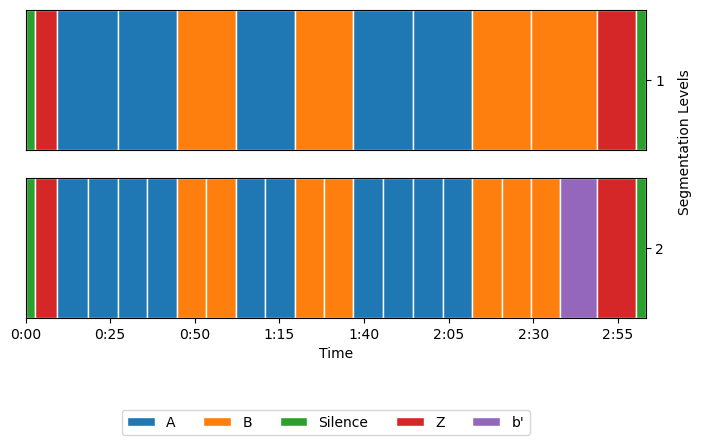

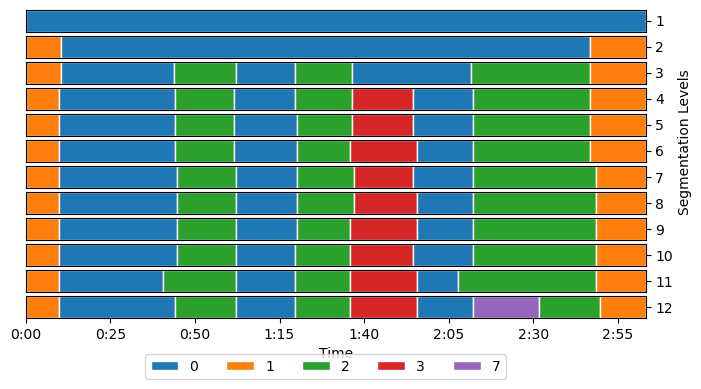

In [39]:
tid = '1010'

ref = bnl.fio.get_ref_hiers(tid)[0]
ref.plot(legend_offset=-0.2)

h = bnl.fio.get_adobe_hiers(tid)
h.plot()

(<Figure size 800x400 with 12 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: xlabel='Time'>], dtype=object))

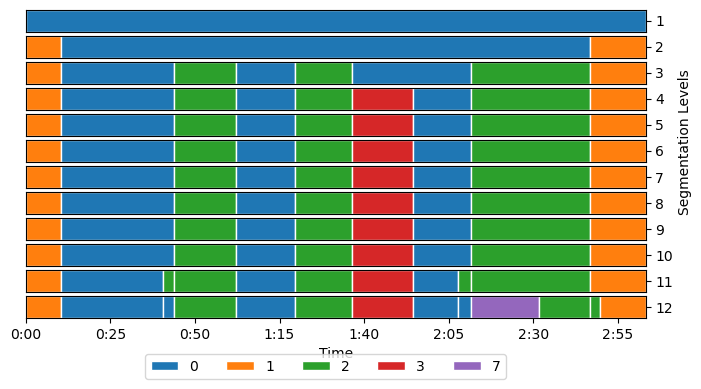

In [40]:
h_monob = h.force_mono_B(min_seg_dur=2)
h_monob.plot()

(<Figure size 800x400 with 6 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: xlabel='Time'>], dtype=object))

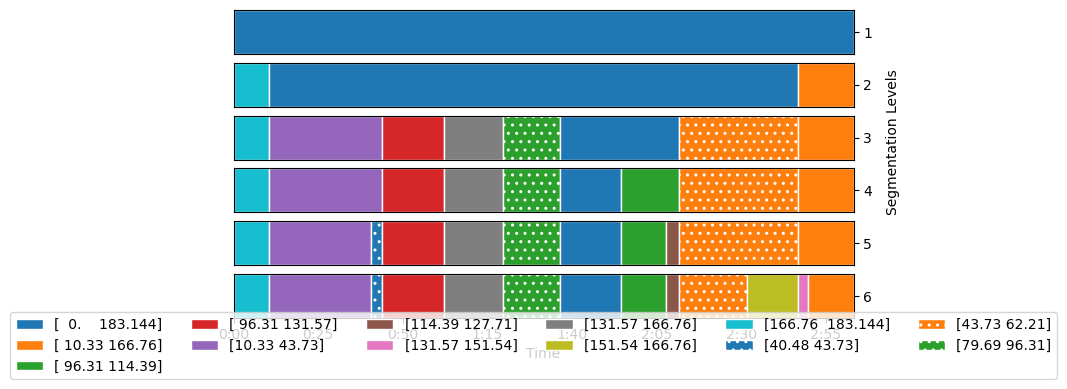

In [41]:
h_monob_pruned = h_monob.prune_identical_levels(boundary_only=True)
h_monob_pruned.plot()

In [42]:
full_results = []
reduced_results = []
for est in (h, h_monob, h_monob_pruned):
    full_results.append(mir_eval.hierarchy.tmeasure(ref.itvls, est.itvls, transitive=True))
    reduced_results.append(mir_eval.hierarchy.tmeasure(ref.itvls, est.itvls, transitive=False))


/Users/tomxi/mir_eval/mir_eval/hierarchy.py:504: UserWarning: Segment hierarchy is inconsistent at level 3
  warnings.warn(
/Users/tomxi/mir_eval/mir_eval/hierarchy.py:504: UserWarning: Segment hierarchy is inconsistent at level 4
  warnings.warn(
/Users/tomxi/mir_eval/mir_eval/hierarchy.py:504: UserWarning: Segment hierarchy is inconsistent at level 5
  warnings.warn(
/Users/tomxi/mir_eval/mir_eval/hierarchy.py:504: UserWarning: Segment hierarchy is inconsistent at level 6
  warnings.warn(
/Users/tomxi/mir_eval/mir_eval/hierarchy.py:504: UserWarning: Segment hierarchy is inconsistent at level 7
  warnings.warn(
/Users/tomxi/mir_eval/mir_eval/hierarchy.py:504: UserWarning: Segment hierarchy is inconsistent at level 8
  warnings.warn(
/Users/tomxi/mir_eval/mir_eval/hierarchy.py:504: UserWarning: Segment hierarchy is inconsistent at level 9
  warnings.warn(
/Users/tomxi/mir_eval/mir_eval/hierarchy.py:504: UserWarning: Segment hierarchy is inconsistent at level 10
  warnings.warn(
/Users/

In [43]:
print('\t raw, mono, mono2')
print('f', full_results)
print('r', reduced_results)

	 raw, mono, mono2
f [(0.7875013415420787, 0.6084734644949544, 0.6865076182038506), (0.7633295472530637, 0.6124890766215021, 0.6796404721405535), (0.7633295472530637, 0.6124890766215021, 0.6796404721405535)]
r [(0.5752160073577076, 0.4848954768873518, 0.5262081287603106), (0.45112558126345187, 0.5061357880224462, 0.47705006990973114), (0.5493211795803741, 0.5061357880224462, 0.526844990631505)]


Having layers with identical boundaries wouldn't affect full_results, but would affect reduced_results.

We can add 1 boundary per hierarchy, and then delete levels to see if things actaully change...

Squashing -> less info to recall. All the info that was recalled right previously will still be right. Therefore squashing ref would increase recall, squahsing est would increase precision
Reduced -> less info to recall on ref. less info predicted on est.

Now I really want the per-frame metric visualization and number of pairs being considered.

In [5]:
from tests import make_hierarchies
import bnl
from bnl import metrics
import numpy as np

h_ref = make_hierarchies()["h2"]
h_est = make_hierarchies()["h1"]

In [16]:
metrics.recall(h_ref, h_est, transitive=False, window=2)

0.0632453323526378

In [39]:
s_ref = metrics.get_segment_relevence(h_ref, 2.1)
s_est = metrics.get_segment_relevence(h_est, 2.1)
common_bs = sorted(list(set(s_ref.beta).union(s_est.beta)))
compare_fn = np.frompyfunc(lambda x, y: int(x) - int(y) == 1, 2, 1)
ref_orientation = s_ref.A(bs=common_bs, compare_fn=compare_fn)
est_orientation = s_est.A(bs=common_bs, compare_fn=np.greater)

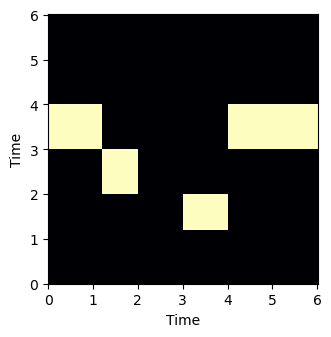

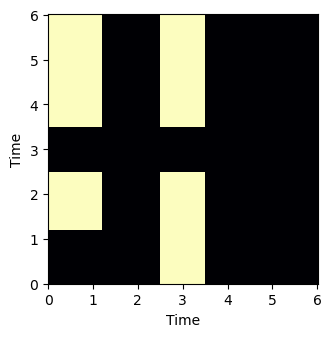

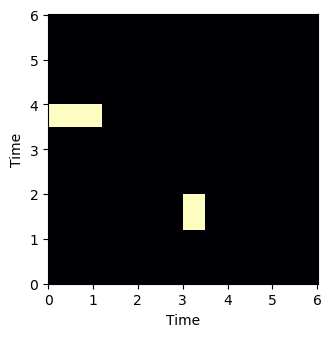

In [42]:
bnl.viz.sq(mat=ref_orientation, ticks=common_bs)
bnl.viz.sq(mat=est_orientation, ticks=common_bs)
bnl.viz.sq(mat=est_orientation * ref_orientation, ticks=common_bs)

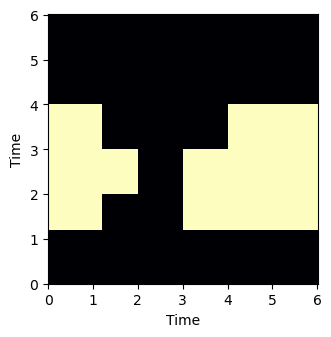

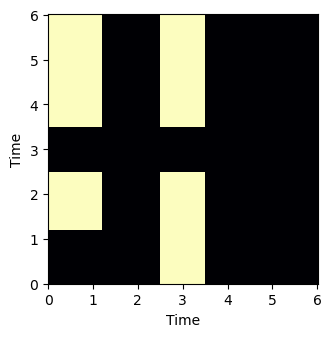

In [ ]:
bnl.viz.sq(mat=ref_orientation, ticks=common_bs)
bnl.viz.sq(mat=est_orientation, ticks=common_bs)

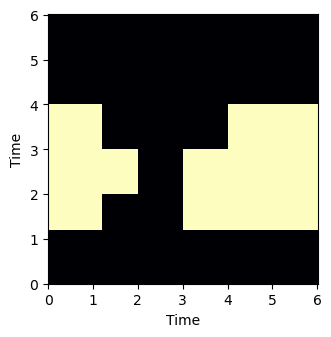

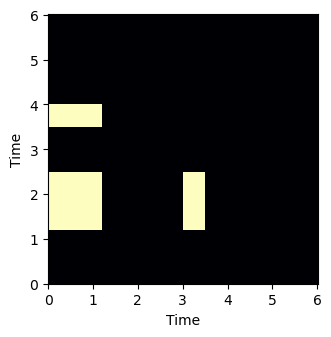

In [51]:
positions_to_recall = s_ref.A(bs=common_bs, compare_fn=np.greater)
positions_recalled = s_est.A(bs=common_bs, compare_fn=np.greater) * positions_to_recall
bnl.viz.sq(mat=positions_to_recall, ticks=common_bs)
bnl.viz.sq(mat=positions_recalled, ticks=common_bs)

In [ ]:
common_grid_area = bnl.utils.bs2grid_area(common_bs)
area_to_recall = np.sum(positions_to_recall * common_grid_area)
area_recalled = np.sum(positions_recalled * common_grid_area)
print(f"Recall: {area_recalled / area_to_recall}")

Recall: 0.24249223334483946


In [57]:
print('r', metrics.recall_at_t(h_ref, h_est, t=2))
print('p', metrics.recall_at_t(h_est, h_ref, t=2))

r 0.24249223334483946
p 0.2932581924441661


In [44]:
s_ref.itvls

array([[0.  , 1.2 ],
       [1.2 , 2.  ],
       [2.  , 3.  ],
       [3.  , 4.  ],
       [4.  , 4.7 ],
       [4.7 , 5.3 ],
       [5.3 , 6.01]])

In [65]:
print(metrics.precision(h_ref.unique_labeling(), h_est.unique_labeling(), transitive=False, window=2), 
      metrics.recall(h_ref.unique_labeling(), h_est.unique_labeling(), transitive=False, window=2))


0.6196244479506 0.15979526592734145


In [66]:
tmeasure(h_ref.itvls, h_est.itvls, frame_size=0.01, transitive=False, window=2)


(0.6162483967522175, 0.16273987790443795, 0.25748317942388604)

In [67]:
tmeasure(h_ref.itvls, h_est.itvls, frame_size=0.005, transitive=False, window=2)


(0.6163154666180901, 0.16189216763749406, 0.25642680037381105)

In [20]:
tmeasure(h_ref.itvls, h_est.itvls, frame_size=0.001, transitive=True, window=3)

(0.5926641263317306, 0.5985211330830352, 0.5955782303820834)

In [60]:
a = np.array((1, np.nan, 2))

In [62]:
~np.isnan(a)

array([ True, False,  True])